In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 110.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 55.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# --- Step 1: Load stock data ---
stock_prices = pd.read_csv("/work/GOOGL.csv", parse_dates=["Date"], index_col="Date")["Close"]

# --- Step 2: Compute Log Returns ---
log_returns = np.log(stock_prices / stock_prices.shift(1)).dropna()

# --- Step 3: Sliding Window Evaluation ---
def evaluate_window(log_returns, stock_prices, window_size, test_size=0.2):
    train_size = int(len(log_returns) * (1 - test_size))
    train, test = log_returns[:train_size], log_returns[train_size:]
    
    predictions = []
    price_predictions = []
    last_train_price = stock_prices.iloc[train_size - 1]
    price_predictions.append(last_train_price)

    for t in range(len(test)):
        # Define rolling window
        start_idx = train_size + t - window_size
        if start_idx < 0:
            window_data = log_returns[:train_size + t]
        else:
            window_data = log_returns[start_idx:train_size + t]

        # Fit ARIMA
        model = auto_arima(
            window_data.values,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore"
        )

        # Forecast 1-step log return
        forecast = model.predict(n_periods=1)[0]
        predictions.append(forecast)
        # Convert to price
        price_predictions.append(price_predictions[-1] * np.exp(forecast))

    # Drop the initial seed (last_train_price)
    price_predictions = price_predictions[1:]

    # --- Ensure same length ---
    predictions = np.array(predictions)
    test = test[:len(predictions)]
    actual_prices = stock_prices.iloc[train_size:train_size + len(price_predictions)]

    # --- Metrics in log-return space ---
    mae_log = mean_absolute_error(test, predictions)
    rmse_log = np.sqrt(mean_squared_error(test, predictions))

    # --- Metrics in price space ---
    mae_price = mean_absolute_error(actual_prices, price_predictions)
    rmse_price = np.sqrt(mean_squared_error(actual_prices, price_predictions))

    # --- Direction Accuracy ---
    direction_accuracy = np.mean(
        np.sign(np.diff(actual_prices.values)) == np.sign(np.diff(price_predictions))
    )

    return {
        "MAE_Log": mae_log,
        "RMSE_Log": rmse_log,
        "MAE_Price": mae_price,
        "RMSE_Price": rmse_price,
        "Direction_Accuracy": direction_accuracy,
        "Price_Predictions": price_predictions,  # Store predictions
        "Actual_Prices": actual_prices  # Store actual prices
    }

# --- Step 4: Test multiple window sizes ---
window_sizes = [30, 60, 90, 120, 180, 200, 250]
results = {}

for w in window_sizes:
    print(f"Evaluating window size: {w}")
    metrics = evaluate_window(log_returns, stock_prices, w)
    results[w] = metrics

results_df = pd.DataFrame({k: {kk: vv for kk, vv in v.items() if kk not in ['Price_Predictions', 'Actual_Prices']} for k, v in results.items()}).T.sort_values("RMSE_Price")
print("\nSliding Window Evaluation Results:")
print(results_df)

best_rmse_window = results_df.index[0]
print(f"\n✅ Best window for RMSE (Price): {best_rmse_window} days")

Evaluating window size: 30
Evaluating window size: 60
Evaluating window size: 90
Evaluating window size: 120
Evaluating window size: 180
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/root/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
Evaluating window size: 200
Evaluating window size: 250

Sliding Window Evaluation Results:
      MAE_Log  RMSE_Log   MAE_Price  RMSE_Price  Direction_Accuracy
90   0.013572  0.019500  589.623929  767.501125            0.220339
250  0.013374  0.019387  591.532659  794.248966            0.325424
200  0.013437  0.019336  608.357138  805.855776            0.277966
30   0.013885  0.019906  595.957410  813.015790            0.170621
180  0.013556  0.019484  618.712818  820.254764  

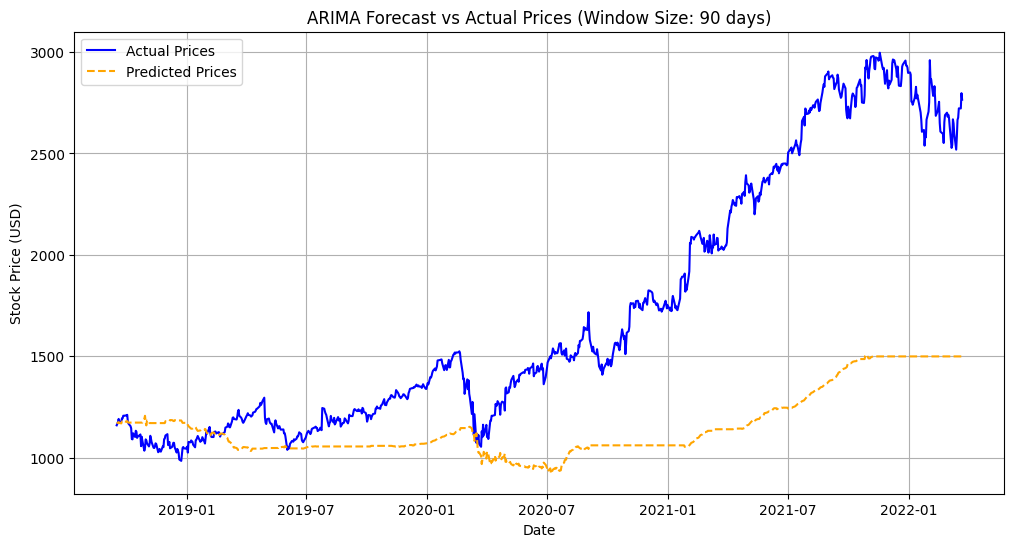

In [3]:
# --- Step 5: Plot the forecast for the best window ---
best_metrics = results[best_rmse_window]
actual_prices = best_metrics['Actual_Prices']
price_predictions = best_metrics['Price_Predictions']

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(actual_prices.index, actual_prices, label='Actual Prices', color='blue')
plt.plot(actual_prices.index[:len(price_predictions)], price_predictions, label='Predicted Prices', color='orange', linestyle='--')
plt.title(f'ARIMA Forecast vs Actual Prices (Window Size: {best_rmse_window} days)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from itertools import product
import json

# -------------------------
# Dataset
# -------------------------
class StockDataset(Dataset):
    """Custom Dataset for stock price time-series forecasting."""
    def __init__(self, series, seq_length):
        self.series = series
        self.seq_length = seq_length

    def __len__(self):
        return len(self.series) - self.seq_length

    def __getitem__(self, idx):
        x = self.series[idx:idx + self.seq_length]  # Shape: (seq_length,)
        y = self.series[idx + self.seq_length]      # Shape: scalar
        x = np.expand_dims(x, axis=0)               # Shape: (1, seq_length)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# -------------------------
# TCN Blocks
# -------------------------
class TemporalBlock(nn.Module):
    """Temporal Convolutional Network block with causal dilated convolutions."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, dropout=0.2):
        super().__init__()
        padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = out[:, :, :x.size(2)]  # Trim padding
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)
        out = out[:, :, :x.size(2)]  # Trim padding
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    """Temporal Convolutional Network for time-series forecasting."""
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers.append(
                TemporalBlock(in_channels, out_channels, kernel_size,
                              stride=1, dilation=dilation_size, dropout=dropout)
            )
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        out = self.network(x)
        out = out[:, :, -1]
        return self.linear(out)

# -------------------------
# Forecaster
# -------------------------
class StockPriceForecaster:
    """Stock price forecasting with TCN model."""
    def __init__(self, dataset_path, seq_length=30, batch_size=32, lr=0.001, epochs=20,
                 kernel_size=3, num_channels=[32, 64, 64], dropout=0.2, test_split=0.2):
        self.dataset_path = dataset_path
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.kernel_size = kernel_size
        self.num_channels = num_channels
        self.dropout = dropout
        self.test_split = test_split
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.scaler = MinMaxScaler()

    def load_data(self):
        """Load and preprocess stock price data."""
        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset file not found at: {self.dataset_path}")
        df = pd.read_csv(self.dataset_path)
        if "Close" not in df.columns:
            raise ValueError("CSV file must contain a 'Close' column")
        prices = df["Close"].values.reshape(-1, 1)
        prices_scaled = self.scaler.fit_transform(prices).flatten()
        dataset = StockDataset(prices_scaled, self.seq_length)
        train_size = int(len(dataset) * (1 - self.test_split))
        test_size = len(dataset) - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)
        return train_loader, test_loader

    def train(self, model, train_loader):
        """Train the TCN model."""
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        model.train()
        for epoch in range(self.epochs):
            epoch_loss = 0
            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                output = model(x)
                loss = criterion(output.squeeze(), y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {epoch_loss/len(train_loader):.6f}")
        return model

    def evaluate(self, model, test_loader):
        """Evaluate the model on the test set."""
        model.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(self.device), y.to(self.device)
                output = model(x)
                predictions.extend(output.squeeze().cpu().numpy())
                actuals.extend(y.cpu().numpy())
        predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
        actuals = self.scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
        mae = mean_absolute_error(actuals, predictions)
        rmse = mean_squared_error(actuals, predictions, squared=False)
        mape = np.mean(np.abs((actuals - predictions) / (actuals + 1e-10))) * 100
        r2 = r2_score(actuals, predictions)
        return mae, rmse, mape, r2, actuals, predictions

    def run(self):
        """Run training and evaluation."""
        train_loader, test_loader = self.load_data()
        model = TCN(input_size=1, output_size=1,
                    num_channels=self.num_channels,
                    kernel_size=self.kernel_size,
                    dropout=self.dropout).to(self.device)
        trained_model = self.train(model, train_loader)
        return trained_model, self.evaluate(model, test_loader)

# -------------------------
# Save Model for Hugging Face
# -------------------------
def save_model_for_huggingface(model, scaler, config, save_dir="tcn_stock_model"):
    """Save the model and necessary components for Hugging Face deployment."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model weights
    torch.save(model.state_dict(), os.path.join(save_dir, "pytorch_model.bin"))
    
    # Save model configuration
    with open(os.path.join(save_dir, "config.json"), "w") as f:
        json.dump({
            "input_size": 1,
            "output_size": 1,
            "num_channels": config["num_channels"],
            "kernel_size": config["kernel_size"],
            "dropout": config["dropout"],
            "seq_length": config["seq_length"]
        }, f, indent=4)
    
    # Save scaler for preprocessing
    import pickle
    with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Model saved to {save_dir}")

# -------------------------
# Experiment Loop
# -------------------------
if __name__ == "__main__":
    dataset_path = "/work/GOOGL.csv"  # Update to your CSV path

    # Hyperparameter grid
    seq_lengths = [20, 50]
    batch_sizes = [16, 32]
    learning_rates = [0.001, 0.0005]
    kernel_sizes = [3, 5]
    num_channels_list = [[32, 64, 128], [64, 128, 256]]
    dropouts = [0.1, 0.2]

    results = []
    best_result = None
    best_metrics = float('inf')  # Track best RMSE
    best_model = None
    best_config = None

    # Run experiments
    for seq, batch, lr, kernel, channels, dropout in product(
        seq_lengths, batch_sizes, learning_rates, kernel_sizes, num_channels_list, dropouts
    ):
        print(f"\nRunning: seq={seq}, batch={batch}, lr={lr}, kernel={kernel}, channels={channels}, dropout={dropout}")
        try:
            forecaster = StockPriceForecaster(
                dataset_path=dataset_path,
                seq_length=seq,
                batch_size=batch,
                lr=lr,
                epochs=20,
                kernel_size=kernel,
                num_channels=channels,
                dropout=dropout,
                test_split=0.2
            )
            model, (mae, rmse, mape, r2, actuals, predictions) = forecaster.run()
            results.append({
                "seq_length": seq,
                "batch_size": batch,
                "lr": lr,
                "kernel_size": kernel,
                "num_channels": str(channels),
                "dropout": dropout,
                "MAE": mae,
                "RMSE": rmse,
                "MAPE": mape,
                "R2": r2
            })
            if rmse < best_metrics:
                best_metrics = rmse
                best_result = (actuals, predictions, seq, batch, lr, kernel, channels, dropout)
                best_model = model
                best_config = {
                    "seq_length": seq,
                    "batch_size": batch,
                    "lr": lr,
                    "kernel_size": kernel,
                    "num_channels": channels,
                    "dropout": dropout
                }
        except Exception as e:
            print(f"Error with config seq={seq}, batch={batch}, lr={lr}, kernel={kernel}, channels={channels}, dropout={dropout}: {e}")
            continue

    # Save results
    df_results = pd.DataFrame(results)
    df_results.to_csv("tcn_experiments_results.csv", index=False)
    print("\nAll experiments done! Results saved to 'tcn_experiments_results.csv'")

    # Display metrics table
    print("\nMetrics Table:")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    pd.set_option('display.float_format', '{:.6f}'.format)
    print(df_results)

    # Save best model for Hugging Face
    if best_model is not None:
        save_model_for_huggingface(best_model, forecaster.scaler, best_config)
        print(f"\nBest model saved with RMSE: {best_metrics:.6f}")
        print("\nBest configuration:")
        print(pd.Series(best_config))

    # Plot best combination
    if best_result is not None:
        actuals, predictions, seq, batch, lr, kernel, channels, dropout = best_result
        plt.figure(figsize=(12, 6))
        plt.plot(actuals, label="Actual Prices")
        plt.plot(predictions, label="Predicted Prices")
        plt.title(f"Best Model: seq={seq}, batch={batch}, lr={lr}, kernel={kernel}, channels={channels}, dropout={dropout}")
        plt.xlabel("Time Step")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No successful experiments to plot.")

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

Running: seq=20, batch=16, lr=0.001, kernel=3, channels=[32, 64, 128], dropout=0.1
Epoch [1/20], Loss: 0.002988
Epoch [2/20], Loss: 0.000468
Epoch [3/20], Loss: 0.000200
Epoch [4/20], Loss: 0.000171
Epoch [5/20], Loss: 0.000096


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=22d36e8e-f07d-4169-ad1b-21cc5c90c096' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>